# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

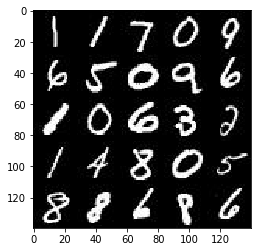

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

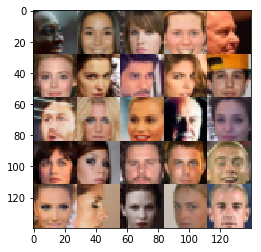

In [4]:
show_n_images = 25
from glob import glob
import os

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Swish Function

f(x) = x * sigmoid(x)

Swish tends to work better then Relu Activation Functions on some models

In [7]:
def swish(x):
    return x * tf.sigmoid(x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    keep_prob = 0.7

    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):

        # Input: 28x28x1 = MNIST / 28x28x3 CelebA
        # Convolution Layer 1
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        conv1 = swish(conv1)
        
        # -> Output c1: 14x14x64
        
        # Convolution Layer 2
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = swish(conv2)
        #conv2 = tf.nn.dropout(conv2, keep_prob=keep_prob)
        
        # -> Output conv2: 7x7x128
        
        # Convolution Layer 3
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = swish(conv3)
        #conv3 = tf.nn.dropout(conv3, keep_prob=keep_prob)
        
        # -> Output conv3: 4x4x256

        # Flatten Layer
        flat = tf.reshape(conv3, (-1, 2*2*512))
        
        # -> Output flat: 2x2x512

        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, reuse=False, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    keep_prob = 0.9

    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        
        # Dense Layer
        dense_layer = tf.layers.dense(z, 2*2*512, activation=None)
        dense_layer = tf.reshape(dense_layer, [-1,2,2,512])
        dense_layer = tf.layers.batch_normalization(dense_layer, training=is_train)
        dense_layer = swish(dense_layer) 
        
        # -> Output dense_layer: 2x2x512
    
        # Convolution Layer 1
        conv1 = tf.layers.conv2d_transpose(dense_layer, 256, 5, strides=2, padding='valid')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = swish(conv1) 
        #conv1 = tf.nn.dropout(conv1, keep_prob=keep_prob)

        # -> Output conv1: 7x7x256

        # Convolution Layer 2
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = swish(conv2) 
        #conv2 = tf.nn.dropout(conv2, keep_prob=keep_prob)

        # -> Output conv2: 14x14x128
        
        # Convolution Layer 3
        conv3 = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, strides=2, padding='same')
        #conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        #conv3 = tf.maximum(alpha * conv3, conv3)

        # -> Output conv3: 28x28x1 = MNIST / 28x28x3 CelebA
        
        logits = conv3
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    generator_model = generator(input_z, out_channel_dim)

    discriminator_real, discriminator_logits_real = discriminator(input_real)
    discriminator_fake, discriminator_logits_fake = discriminator(generator_model, reuse=True)

    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_fake)))

    discriminator_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, labels=tf.ones_like(discriminator_real)))
    discriminator_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.zeros_like(discriminator_fake)))
    discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    # Getting vars (Weights/Bias)
    tensor_vars = tf.trainable_variables()
    discriminator_vars = [var for var in tensor_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in tensor_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        discriminator_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_vars)
        generator_train_opt = tf.train.AdamOptimizer(0.001, beta1=beta1).minimize(g_loss, var_list=generator_vars)

    return discriminator_train_opt, generator_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

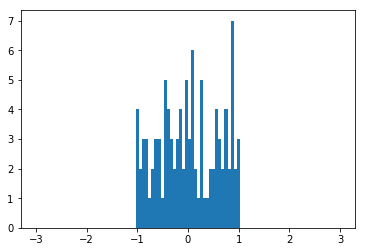

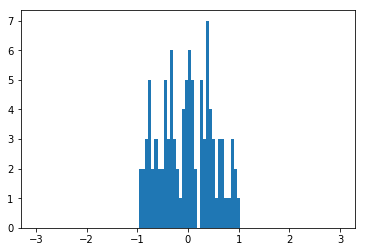

In [21]:
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import scipy.stats as stats

random_uniform = np.random.uniform(-1, 1, size=100)
truncnorm = truncnorm.rvs(-1, 1, size=100)

plt.hist(random_uniform, 100, (-3, 3));
plt.show()

plt.hist(truncnorm, 100, (-3, 3))
plt.show()

In [20]:
from scipy.stats import truncnorm

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, learning_rate_tensor = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                #batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_z = truncnorm.rvs(-1, 1, size=(batch_size, z_dim))

                
                # Run optimizers
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_tensor: learning_rate})
                sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learning_rate_tensor: learning_rate})
                
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
        print("End")
                    

                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.1813... Generator Loss: 2.7622
Epoch 0/2... Discriminator Loss: 0.1842... Generator Loss: 2.3563
Epoch 0/2... Discriminator Loss: 0.1603... Generator Loss: 3.6811
Epoch 0/2... Discriminator Loss: 0.2382... Generator Loss: 2.5029
Epoch 0/2... Discriminator Loss: 0.5067... Generator Loss: 3.0249
Epoch 0/2... Discriminator Loss: 0.4160... Generator Loss: 1.6156
Epoch 0/2... Discriminator Loss: 0.6651... Generator Loss: 1.0677
Epoch 0/2... Discriminator Loss: 0.3287... Generator Loss: 2.3608
Epoch 0/2... Discriminator Loss: 0.4059... Generator Loss: 1.8398


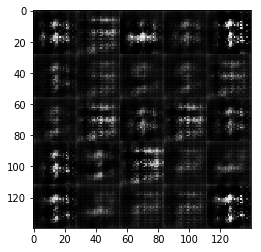

Epoch 0/2... Discriminator Loss: 0.3273... Generator Loss: 2.5005
Epoch 0/2... Discriminator Loss: 0.1705... Generator Loss: 2.4842
Epoch 0/2... Discriminator Loss: 0.1644... Generator Loss: 2.5658
Epoch 0/2... Discriminator Loss: 0.7495... Generator Loss: 0.8144
Epoch 0/2... Discriminator Loss: 0.2110... Generator Loss: 3.4706
Epoch 0/2... Discriminator Loss: 0.2764... Generator Loss: 1.8154
Epoch 0/2... Discriminator Loss: 0.1244... Generator Loss: 2.9276
Epoch 0/2... Discriminator Loss: 0.2153... Generator Loss: 1.9120
Epoch 0/2... Discriminator Loss: 0.2936... Generator Loss: 2.1681
Epoch 0/2... Discriminator Loss: 0.1224... Generator Loss: 3.2024


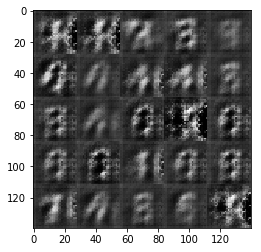

Epoch 0/2... Discriminator Loss: 0.9379... Generator Loss: 1.3240
Epoch 0/2... Discriminator Loss: 0.4872... Generator Loss: 1.7872
Epoch 0/2... Discriminator Loss: 0.7455... Generator Loss: 0.7840
Epoch 0/2... Discriminator Loss: 0.7241... Generator Loss: 0.8263
Epoch 0/2... Discriminator Loss: 1.5539... Generator Loss: 0.3792
Epoch 0/2... Discriminator Loss: 0.5358... Generator Loss: 1.2766
Epoch 0/2... Discriminator Loss: 0.3380... Generator Loss: 1.9382
Epoch 0/2... Discriminator Loss: 0.4932... Generator Loss: 1.7639
Epoch 0/2... Discriminator Loss: 0.4919... Generator Loss: 1.4261
Epoch 0/2... Discriminator Loss: 0.6676... Generator Loss: 1.4793


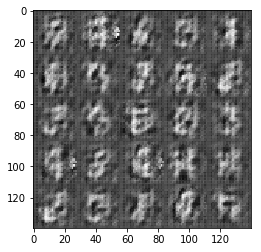

Epoch 0/2... Discriminator Loss: 0.8426... Generator Loss: 0.8519
Epoch 0/2... Discriminator Loss: 0.7008... Generator Loss: 1.7226
Epoch 0/2... Discriminator Loss: 0.6665... Generator Loss: 1.0734
Epoch 0/2... Discriminator Loss: 0.8772... Generator Loss: 3.7463
Epoch 0/2... Discriminator Loss: 0.8628... Generator Loss: 0.8015
Epoch 0/2... Discriminator Loss: 0.7756... Generator Loss: 2.4186
Epoch 0/2... Discriminator Loss: 0.4818... Generator Loss: 1.7190
Epoch 0/2... Discriminator Loss: 0.7051... Generator Loss: 1.0020
Epoch 0/2... Discriminator Loss: 0.3975... Generator Loss: 1.6559
Epoch 0/2... Discriminator Loss: 0.4565... Generator Loss: 1.5687


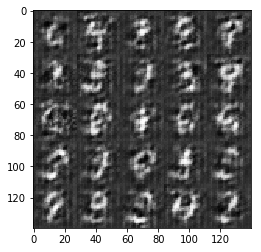

Epoch 0/2... Discriminator Loss: 0.4633... Generator Loss: 1.4824
Epoch 0/2... Discriminator Loss: 0.5555... Generator Loss: 1.5966
Epoch 0/2... Discriminator Loss: 0.6454... Generator Loss: 1.1001
Epoch 0/2... Discriminator Loss: 0.8553... Generator Loss: 0.8229
Epoch 0/2... Discriminator Loss: 0.4486... Generator Loss: 1.8223
Epoch 0/2... Discriminator Loss: 0.4870... Generator Loss: 1.5636
Epoch 0/2... Discriminator Loss: 0.6024... Generator Loss: 1.1609
Epoch 0/2... Discriminator Loss: 1.6137... Generator Loss: 3.4506
Epoch 0/2... Discriminator Loss: 0.5633... Generator Loss: 1.9536
Epoch 0/2... Discriminator Loss: 0.5013... Generator Loss: 1.5370


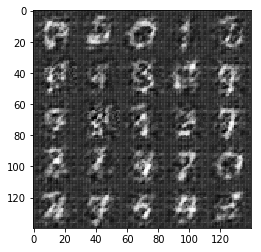

Epoch 0/2... Discriminator Loss: 0.9568... Generator Loss: 2.9836
Epoch 0/2... Discriminator Loss: 0.5690... Generator Loss: 1.2145
Epoch 0/2... Discriminator Loss: 0.5980... Generator Loss: 1.0818
Epoch 0/2... Discriminator Loss: 0.7198... Generator Loss: 1.9528
Epoch 0/2... Discriminator Loss: 0.7903... Generator Loss: 1.0739
Epoch 0/2... Discriminator Loss: 0.5806... Generator Loss: 1.2070
Epoch 0/2... Discriminator Loss: 0.5889... Generator Loss: 1.1452
Epoch 0/2... Discriminator Loss: 0.3745... Generator Loss: 2.0330
Epoch 0/2... Discriminator Loss: 0.4302... Generator Loss: 1.9806
Epoch 0/2... Discriminator Loss: 0.5410... Generator Loss: 1.6907


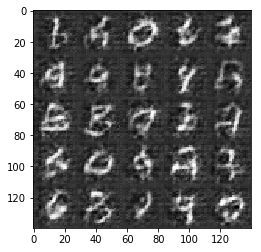

Epoch 0/2... Discriminator Loss: 0.4013... Generator Loss: 3.2310
Epoch 0/2... Discriminator Loss: 0.4824... Generator Loss: 1.4378
Epoch 0/2... Discriminator Loss: 0.4133... Generator Loss: 1.7088
Epoch 0/2... Discriminator Loss: 0.4941... Generator Loss: 1.8208
Epoch 0/2... Discriminator Loss: 1.9027... Generator Loss: 0.3076
Epoch 0/2... Discriminator Loss: 0.7388... Generator Loss: 1.2830
Epoch 0/2... Discriminator Loss: 0.6317... Generator Loss: 1.2230
Epoch 0/2... Discriminator Loss: 0.5096... Generator Loss: 1.6214
Epoch 0/2... Discriminator Loss: 1.2902... Generator Loss: 3.2008
Epoch 0/2... Discriminator Loss: 0.4613... Generator Loss: 1.4261


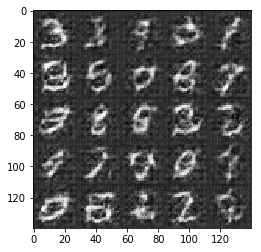

Epoch 0/2... Discriminator Loss: 0.3743... Generator Loss: 2.2736
Epoch 0/2... Discriminator Loss: 0.4221... Generator Loss: 1.4995
Epoch 0/2... Discriminator Loss: 0.3651... Generator Loss: 1.5443
Epoch 0/2... Discriminator Loss: 0.5884... Generator Loss: 2.6953
Epoch 0/2... Discriminator Loss: 1.1183... Generator Loss: 0.7561
Epoch 0/2... Discriminator Loss: 0.8035... Generator Loss: 1.1898
Epoch 0/2... Discriminator Loss: 0.6210... Generator Loss: 1.1526
Epoch 0/2... Discriminator Loss: 0.4558... Generator Loss: 1.9521
Epoch 0/2... Discriminator Loss: 0.5640... Generator Loss: 1.2209
Epoch 0/2... Discriminator Loss: 0.4763... Generator Loss: 1.4585


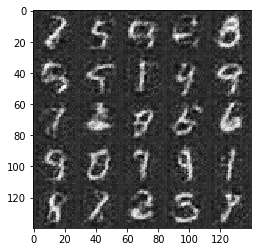

Epoch 0/2... Discriminator Loss: 0.4611... Generator Loss: 1.2898
Epoch 0/2... Discriminator Loss: 0.5121... Generator Loss: 1.1852
Epoch 0/2... Discriminator Loss: 0.3853... Generator Loss: 1.7828
Epoch 0/2... Discriminator Loss: 0.3597... Generator Loss: 1.8386
Epoch 0/2... Discriminator Loss: 0.6050... Generator Loss: 1.1390
Epoch 0/2... Discriminator Loss: 0.8563... Generator Loss: 1.0974
Epoch 0/2... Discriminator Loss: 0.5790... Generator Loss: 1.3447
Epoch 0/2... Discriminator Loss: 0.5349... Generator Loss: 1.2232
Epoch 0/2... Discriminator Loss: 0.4078... Generator Loss: 1.7044
Epoch 0/2... Discriminator Loss: 0.3873... Generator Loss: 1.5232


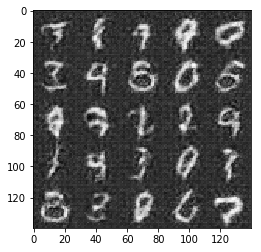

Epoch 0/2... Discriminator Loss: 0.3291... Generator Loss: 1.7100
Epoch 0/2... Discriminator Loss: 1.7255... Generator Loss: 0.2994
Epoch 0/2... Discriminator Loss: 0.5707... Generator Loss: 1.2605
Epoch 0/2... Discriminator Loss: 0.6281... Generator Loss: 1.2114
Epoch 1/2... Discriminator Loss: 0.7081... Generator Loss: 0.9053
Epoch 1/2... Discriminator Loss: 0.7449... Generator Loss: 1.4318
Epoch 1/2... Discriminator Loss: 0.3820... Generator Loss: 2.0370
Epoch 1/2... Discriminator Loss: 0.4268... Generator Loss: 2.3508
Epoch 1/2... Discriminator Loss: 0.5800... Generator Loss: 1.8009
Epoch 1/2... Discriminator Loss: 0.5631... Generator Loss: 1.1193


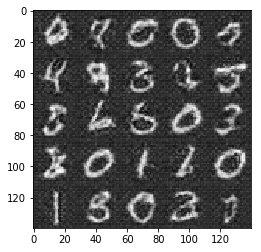

Epoch 1/2... Discriminator Loss: 0.4711... Generator Loss: 1.5116
Epoch 1/2... Discriminator Loss: 0.4031... Generator Loss: 1.8531
Epoch 1/2... Discriminator Loss: 0.4941... Generator Loss: 2.1462
Epoch 1/2... Discriminator Loss: 0.3586... Generator Loss: 1.9855
Epoch 1/2... Discriminator Loss: 2.6189... Generator Loss: 0.2652
Epoch 1/2... Discriminator Loss: 1.0530... Generator Loss: 0.9783
Epoch 1/2... Discriminator Loss: 0.7741... Generator Loss: 1.1725
Epoch 1/2... Discriminator Loss: 0.8000... Generator Loss: 1.1475
Epoch 1/2... Discriminator Loss: 0.7611... Generator Loss: 0.9147
Epoch 1/2... Discriminator Loss: 0.5385... Generator Loss: 1.2690


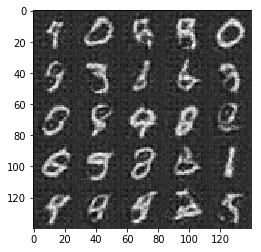

Epoch 1/2... Discriminator Loss: 0.7065... Generator Loss: 2.1329
Epoch 1/2... Discriminator Loss: 0.6733... Generator Loss: 1.2205
Epoch 1/2... Discriminator Loss: 0.8980... Generator Loss: 0.7234
Epoch 1/2... Discriminator Loss: 1.1290... Generator Loss: 0.6499
Epoch 1/2... Discriminator Loss: 0.5371... Generator Loss: 1.6938
Epoch 1/2... Discriminator Loss: 0.4704... Generator Loss: 1.4812
Epoch 1/2... Discriminator Loss: 0.4331... Generator Loss: 1.6176
Epoch 1/2... Discriminator Loss: 0.5544... Generator Loss: 1.1753
Epoch 1/2... Discriminator Loss: 0.4748... Generator Loss: 1.4639
Epoch 1/2... Discriminator Loss: 0.7121... Generator Loss: 0.8636


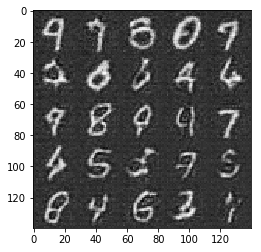

Epoch 1/2... Discriminator Loss: 0.4216... Generator Loss: 1.4907
Epoch 1/2... Discriminator Loss: 0.3698... Generator Loss: 1.8377
Epoch 1/2... Discriminator Loss: 3.6842... Generator Loss: 0.0409
Epoch 1/2... Discriminator Loss: 1.2350... Generator Loss: 0.5968
Epoch 1/2... Discriminator Loss: 0.6729... Generator Loss: 1.0072
Epoch 1/2... Discriminator Loss: 0.6336... Generator Loss: 1.0991
Epoch 1/2... Discriminator Loss: 0.4234... Generator Loss: 1.5699
Epoch 1/2... Discriminator Loss: 0.9077... Generator Loss: 2.0120
Epoch 1/2... Discriminator Loss: 0.4349... Generator Loss: 1.5674
Epoch 1/2... Discriminator Loss: 0.4367... Generator Loss: 1.4371


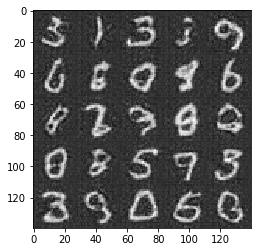

Epoch 1/2... Discriminator Loss: 0.4343... Generator Loss: 1.5203
Epoch 1/2... Discriminator Loss: 0.4765... Generator Loss: 1.4614
Epoch 1/2... Discriminator Loss: 0.4871... Generator Loss: 1.3135
Epoch 1/2... Discriminator Loss: 0.3739... Generator Loss: 1.6152
Epoch 1/2... Discriminator Loss: 0.3687... Generator Loss: 1.5636
Epoch 1/2... Discriminator Loss: 2.2503... Generator Loss: 2.5558
Epoch 1/2... Discriminator Loss: 1.0660... Generator Loss: 0.6535
Epoch 1/2... Discriminator Loss: 0.6922... Generator Loss: 1.3378
Epoch 1/2... Discriminator Loss: 0.4613... Generator Loss: 1.5238
Epoch 1/2... Discriminator Loss: 0.4785... Generator Loss: 1.5706


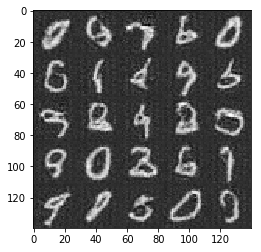

Epoch 1/2... Discriminator Loss: 0.4399... Generator Loss: 1.4050
Epoch 1/2... Discriminator Loss: 1.1587... Generator Loss: 0.4538
Epoch 1/2... Discriminator Loss: 0.8063... Generator Loss: 0.8940
Epoch 1/2... Discriminator Loss: 0.6048... Generator Loss: 1.0641
Epoch 1/2... Discriminator Loss: 0.5230... Generator Loss: 1.3278
Epoch 1/2... Discriminator Loss: 0.4790... Generator Loss: 1.3914
Epoch 1/2... Discriminator Loss: 1.4870... Generator Loss: 2.8025
Epoch 1/2... Discriminator Loss: 0.5900... Generator Loss: 1.3108
Epoch 1/2... Discriminator Loss: 0.5510... Generator Loss: 1.1896
Epoch 1/2... Discriminator Loss: 0.4277... Generator Loss: 1.6445


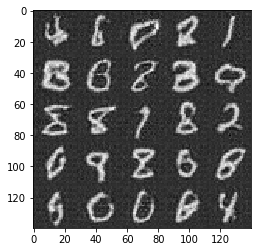

Epoch 1/2... Discriminator Loss: 0.6180... Generator Loss: 1.0122
Epoch 1/2... Discriminator Loss: 0.5437... Generator Loss: 1.2666
Epoch 1/2... Discriminator Loss: 0.4615... Generator Loss: 1.5599
Epoch 1/2... Discriminator Loss: 0.5541... Generator Loss: 1.1693
Epoch 1/2... Discriminator Loss: 0.5283... Generator Loss: 1.5674
Epoch 1/2... Discriminator Loss: 0.5210... Generator Loss: 1.1809
Epoch 1/2... Discriminator Loss: 0.5229... Generator Loss: 1.2211
Epoch 1/2... Discriminator Loss: 2.3538... Generator Loss: 3.1534
Epoch 1/2... Discriminator Loss: 0.6962... Generator Loss: 1.3756
Epoch 1/2... Discriminator Loss: 0.5611... Generator Loss: 1.4221


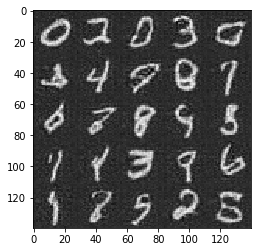

Epoch 1/2... Discriminator Loss: 0.4182... Generator Loss: 1.6754
Epoch 1/2... Discriminator Loss: 0.4363... Generator Loss: 1.5358
Epoch 1/2... Discriminator Loss: 1.1357... Generator Loss: 1.3614
Epoch 1/2... Discriminator Loss: 0.6751... Generator Loss: 1.6601
Epoch 1/2... Discriminator Loss: 0.5952... Generator Loss: 1.2636
Epoch 1/2... Discriminator Loss: 0.5803... Generator Loss: 1.0726
Epoch 1/2... Discriminator Loss: 0.5242... Generator Loss: 1.5791
Epoch 1/2... Discriminator Loss: 0.4989... Generator Loss: 1.2102
Epoch 1/2... Discriminator Loss: 0.4670... Generator Loss: 1.5323
Epoch 1/2... Discriminator Loss: 0.4900... Generator Loss: 1.7552


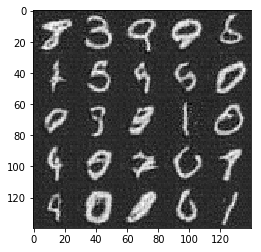

Epoch 1/2... Discriminator Loss: 0.5149... Generator Loss: 1.6433
Epoch 1/2... Discriminator Loss: 0.4036... Generator Loss: 1.7059
Epoch 1/2... Discriminator Loss: 0.4841... Generator Loss: 1.5699
Epoch 1/2... Discriminator Loss: 0.5167... Generator Loss: 2.2723
Epoch 1/2... Discriminator Loss: 1.4442... Generator Loss: 0.6118
Epoch 1/2... Discriminator Loss: 1.1781... Generator Loss: 0.6776
Epoch 1/2... Discriminator Loss: 0.6289... Generator Loss: 1.2130
Epoch 1/2... Discriminator Loss: 0.8903... Generator Loss: 1.0937
Epoch 1/2... Discriminator Loss: 0.4681... Generator Loss: 1.5514
Epoch 1/2... Discriminator Loss: 0.5023... Generator Loss: 1.4456


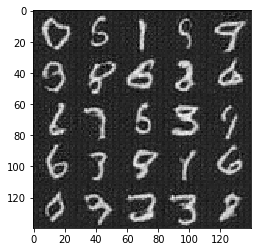

Epoch 1/2... Discriminator Loss: 0.5200... Generator Loss: 1.6604
Epoch 1/2... Discriminator Loss: 0.6062... Generator Loss: 1.3858
Epoch 1/2... Discriminator Loss: 0.5179... Generator Loss: 1.4943
Epoch 1/2... Discriminator Loss: 0.6239... Generator Loss: 1.1161
Epoch 1/2... Discriminator Loss: 0.5803... Generator Loss: 1.2399
Epoch 1/2... Discriminator Loss: 0.4725... Generator Loss: 1.4723
Epoch 1/2... Discriminator Loss: 0.5801... Generator Loss: 1.0337
Epoch 1/2... Discriminator Loss: 0.4297... Generator Loss: 1.5321
End


In [15]:
batch_size = 64
z_dim = 50
learning_rate = 0.0005
beta1 = 0.5

# learning_rate of the generator = 0.001

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 2.1584... Generator Loss: 0.3014
Epoch 0/1... Discriminator Loss: 0.5506... Generator Loss: 1.0069
Epoch 0/1... Discriminator Loss: 0.1820... Generator Loss: 2.1168
Epoch 0/1... Discriminator Loss: 0.1292... Generator Loss: 2.8136
Epoch 0/1... Discriminator Loss: 0.1595... Generator Loss: 2.6426
Epoch 0/1... Discriminator Loss: 0.0801... Generator Loss: 3.2406
Epoch 0/1... Discriminator Loss: 0.0824... Generator Loss: 3.3456
Epoch 0/1... Discriminator Loss: 0.0653... Generator Loss: 3.2915
Epoch 0/1... Discriminator Loss: 0.1073... Generator Loss: 2.8008


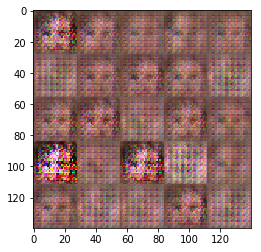

Epoch 0/1... Discriminator Loss: 0.0466... Generator Loss: 3.4468
Epoch 0/1... Discriminator Loss: 0.0536... Generator Loss: 3.2057
Epoch 0/1... Discriminator Loss: 0.0941... Generator Loss: 2.9453
Epoch 0/1... Discriminator Loss: 0.0860... Generator Loss: 2.7718
Epoch 0/1... Discriminator Loss: 0.1120... Generator Loss: 2.5905
Epoch 0/1... Discriminator Loss: 0.0676... Generator Loss: 3.3092
Epoch 0/1... Discriminator Loss: 0.0314... Generator Loss: 4.6373
Epoch 0/1... Discriminator Loss: 0.1384... Generator Loss: 4.6619
Epoch 0/1... Discriminator Loss: 0.2528... Generator Loss: 3.9012
Epoch 0/1... Discriminator Loss: 1.4263... Generator Loss: 0.3388


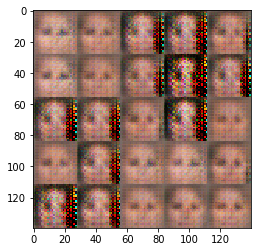

Epoch 0/1... Discriminator Loss: 0.6120... Generator Loss: 1.1818
Epoch 0/1... Discriminator Loss: 0.3144... Generator Loss: 1.5099
Epoch 0/1... Discriminator Loss: 0.1014... Generator Loss: 3.8285
Epoch 0/1... Discriminator Loss: 0.1057... Generator Loss: 3.5252
Epoch 0/1... Discriminator Loss: 0.1076... Generator Loss: 3.0621
Epoch 0/1... Discriminator Loss: 1.0506... Generator Loss: 3.5780
Epoch 0/1... Discriminator Loss: 0.4496... Generator Loss: 2.1363
Epoch 0/1... Discriminator Loss: 0.6942... Generator Loss: 0.7988
Epoch 0/1... Discriminator Loss: 0.3746... Generator Loss: 2.9064
Epoch 0/1... Discriminator Loss: 1.3419... Generator Loss: 0.4194


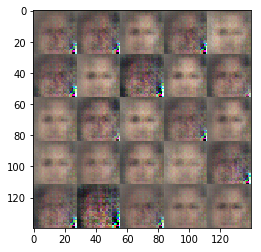

Epoch 0/1... Discriminator Loss: 0.6496... Generator Loss: 1.3660
Epoch 0/1... Discriminator Loss: 0.4631... Generator Loss: 1.4080
Epoch 0/1... Discriminator Loss: 0.7794... Generator Loss: 1.3483
Epoch 0/1... Discriminator Loss: 1.5587... Generator Loss: 1.1389
Epoch 0/1... Discriminator Loss: 1.5194... Generator Loss: 0.7629
Epoch 0/1... Discriminator Loss: 1.0606... Generator Loss: 1.3769
Epoch 0/1... Discriminator Loss: 1.0866... Generator Loss: 1.1517
Epoch 0/1... Discriminator Loss: 0.6049... Generator Loss: 1.4135
Epoch 0/1... Discriminator Loss: 1.2750... Generator Loss: 0.7435
Epoch 0/1... Discriminator Loss: 1.5932... Generator Loss: 1.5952


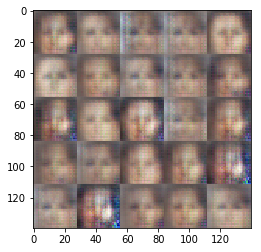

Epoch 0/1... Discriminator Loss: 1.4733... Generator Loss: 1.0194
Epoch 0/1... Discriminator Loss: 1.1482... Generator Loss: 0.7108
Epoch 0/1... Discriminator Loss: 1.3003... Generator Loss: 0.5674
Epoch 0/1... Discriminator Loss: 1.7489... Generator Loss: 0.4240
Epoch 0/1... Discriminator Loss: 1.1609... Generator Loss: 0.8882
Epoch 0/1... Discriminator Loss: 1.3711... Generator Loss: 0.7374
Epoch 0/1... Discriminator Loss: 1.4249... Generator Loss: 1.3571
Epoch 0/1... Discriminator Loss: 0.9324... Generator Loss: 1.0653
Epoch 0/1... Discriminator Loss: 0.9186... Generator Loss: 0.7795
Epoch 0/1... Discriminator Loss: 0.7005... Generator Loss: 0.9572


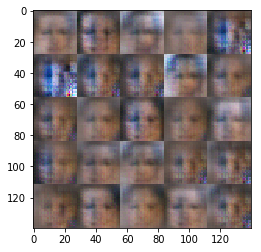

Epoch 0/1... Discriminator Loss: 1.0007... Generator Loss: 1.2163
Epoch 0/1... Discriminator Loss: 1.2015... Generator Loss: 1.0976
Epoch 0/1... Discriminator Loss: 1.4101... Generator Loss: 0.5085
Epoch 0/1... Discriminator Loss: 1.1542... Generator Loss: 0.9162
Epoch 0/1... Discriminator Loss: 1.3778... Generator Loss: 0.7765
Epoch 0/1... Discriminator Loss: 1.5087... Generator Loss: 0.7091
Epoch 0/1... Discriminator Loss: 1.1885... Generator Loss: 0.9247
Epoch 0/1... Discriminator Loss: 1.2571... Generator Loss: 0.7902
Epoch 0/1... Discriminator Loss: 1.6617... Generator Loss: 0.5072
Epoch 0/1... Discriminator Loss: 1.3073... Generator Loss: 0.5329


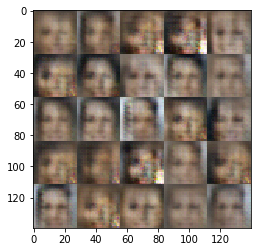

Epoch 0/1... Discriminator Loss: 1.5648... Generator Loss: 0.8265
Epoch 0/1... Discriminator Loss: 1.0960... Generator Loss: 0.5843
Epoch 0/1... Discriminator Loss: 1.0197... Generator Loss: 1.3970
Epoch 0/1... Discriminator Loss: 1.1156... Generator Loss: 0.9110
Epoch 0/1... Discriminator Loss: 1.2582... Generator Loss: 1.3218
Epoch 0/1... Discriminator Loss: 1.4307... Generator Loss: 0.5620
Epoch 0/1... Discriminator Loss: 1.2696... Generator Loss: 1.0473
Epoch 0/1... Discriminator Loss: 1.3299... Generator Loss: 0.9868
Epoch 0/1... Discriminator Loss: 0.8372... Generator Loss: 0.9968
Epoch 0/1... Discriminator Loss: 0.7958... Generator Loss: 1.2680


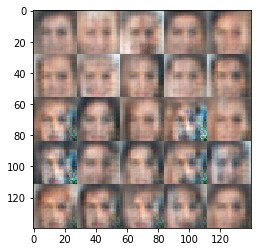

Epoch 0/1... Discriminator Loss: 0.8107... Generator Loss: 1.2421
Epoch 0/1... Discriminator Loss: 1.7976... Generator Loss: 0.4627
Epoch 0/1... Discriminator Loss: 1.0349... Generator Loss: 0.9610
Epoch 0/1... Discriminator Loss: 1.2762... Generator Loss: 0.8196
Epoch 0/1... Discriminator Loss: 1.1403... Generator Loss: 0.8745
Epoch 0/1... Discriminator Loss: 0.9463... Generator Loss: 0.9857
Epoch 0/1... Discriminator Loss: 1.1965... Generator Loss: 1.1175
Epoch 0/1... Discriminator Loss: 1.0980... Generator Loss: 1.3665
Epoch 0/1... Discriminator Loss: 1.1905... Generator Loss: 0.8368
Epoch 0/1... Discriminator Loss: 1.3202... Generator Loss: 0.6972


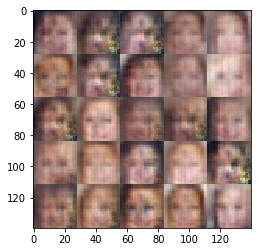

Epoch 0/1... Discriminator Loss: 1.2839... Generator Loss: 0.7005
Epoch 0/1... Discriminator Loss: 2.0392... Generator Loss: 0.2893
Epoch 0/1... Discriminator Loss: 1.0181... Generator Loss: 0.9712
Epoch 0/1... Discriminator Loss: 0.9914... Generator Loss: 0.9718
Epoch 0/1... Discriminator Loss: 1.3729... Generator Loss: 0.5764
Epoch 0/1... Discriminator Loss: 1.2635... Generator Loss: 0.7915
Epoch 0/1... Discriminator Loss: 1.5895... Generator Loss: 0.4284
Epoch 0/1... Discriminator Loss: 0.9705... Generator Loss: 1.3724
Epoch 0/1... Discriminator Loss: 0.8297... Generator Loss: 1.3187
Epoch 0/1... Discriminator Loss: 1.2314... Generator Loss: 1.0839


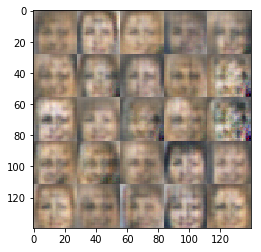

Epoch 0/1... Discriminator Loss: 1.0160... Generator Loss: 1.1040
Epoch 0/1... Discriminator Loss: 0.9540... Generator Loss: 1.3382
Epoch 0/1... Discriminator Loss: 0.7735... Generator Loss: 1.6215
Epoch 0/1... Discriminator Loss: 0.8482... Generator Loss: 1.1049
Epoch 0/1... Discriminator Loss: 1.0592... Generator Loss: 1.1563
Epoch 0/1... Discriminator Loss: 1.3603... Generator Loss: 0.9362
Epoch 0/1... Discriminator Loss: 1.2697... Generator Loss: 0.9797
Epoch 0/1... Discriminator Loss: 1.1901... Generator Loss: 1.1468
Epoch 0/1... Discriminator Loss: 1.0125... Generator Loss: 0.8684
Epoch 0/1... Discriminator Loss: 0.7114... Generator Loss: 2.1222


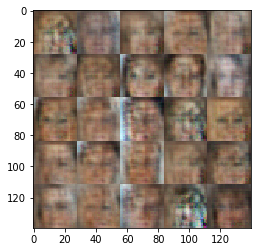

Epoch 0/1... Discriminator Loss: 1.1028... Generator Loss: 1.0291
Epoch 0/1... Discriminator Loss: 0.9964... Generator Loss: 1.4908
Epoch 0/1... Discriminator Loss: 1.1514... Generator Loss: 0.7394
Epoch 0/1... Discriminator Loss: 1.2737... Generator Loss: 0.6240
Epoch 0/1... Discriminator Loss: 1.0907... Generator Loss: 0.9942
Epoch 0/1... Discriminator Loss: 0.9958... Generator Loss: 0.9232
Epoch 0/1... Discriminator Loss: 0.9857... Generator Loss: 0.9405
Epoch 0/1... Discriminator Loss: 0.6399... Generator Loss: 1.8802
Epoch 0/1... Discriminator Loss: 1.0802... Generator Loss: 0.8552
Epoch 0/1... Discriminator Loss: 0.9256... Generator Loss: 0.9874


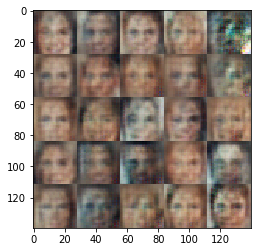

Epoch 0/1... Discriminator Loss: 1.2773... Generator Loss: 0.8734
Epoch 0/1... Discriminator Loss: 0.9692... Generator Loss: 1.3800
Epoch 0/1... Discriminator Loss: 1.0624... Generator Loss: 0.9927
Epoch 0/1... Discriminator Loss: 0.8217... Generator Loss: 1.0385
Epoch 0/1... Discriminator Loss: 0.8932... Generator Loss: 1.1304
Epoch 0/1... Discriminator Loss: 1.1467... Generator Loss: 0.8578
Epoch 0/1... Discriminator Loss: 0.9999... Generator Loss: 1.3372
Epoch 0/1... Discriminator Loss: 0.6092... Generator Loss: 1.5989
Epoch 0/1... Discriminator Loss: 0.6765... Generator Loss: 1.4796
Epoch 0/1... Discriminator Loss: 1.3880... Generator Loss: 0.8905


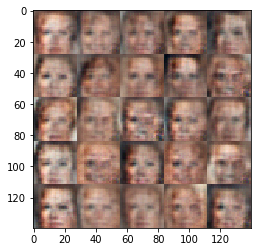

Epoch 0/1... Discriminator Loss: 1.4593... Generator Loss: 0.6681
Epoch 0/1... Discriminator Loss: 1.3393... Generator Loss: 0.5410
Epoch 0/1... Discriminator Loss: 0.7690... Generator Loss: 1.4498
Epoch 0/1... Discriminator Loss: 0.9946... Generator Loss: 0.9081
Epoch 0/1... Discriminator Loss: 0.7600... Generator Loss: 1.3038
Epoch 0/1... Discriminator Loss: 1.1810... Generator Loss: 1.3179
Epoch 0/1... Discriminator Loss: 1.0124... Generator Loss: 1.0294
Epoch 0/1... Discriminator Loss: 0.9856... Generator Loss: 0.7708
Epoch 0/1... Discriminator Loss: 0.9344... Generator Loss: 1.2207
Epoch 0/1... Discriminator Loss: 1.9054... Generator Loss: 0.2971


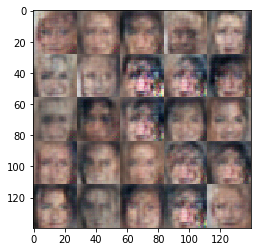

Epoch 0/1... Discriminator Loss: 1.2820... Generator Loss: 0.7542
Epoch 0/1... Discriminator Loss: 0.6626... Generator Loss: 1.4028
Epoch 0/1... Discriminator Loss: 0.9223... Generator Loss: 0.7775
Epoch 0/1... Discriminator Loss: 0.8905... Generator Loss: 1.3263
Epoch 0/1... Discriminator Loss: 1.3932... Generator Loss: 2.0373
Epoch 0/1... Discriminator Loss: 0.7670... Generator Loss: 1.1774
Epoch 0/1... Discriminator Loss: 0.5857... Generator Loss: 1.3593
Epoch 0/1... Discriminator Loss: 0.8200... Generator Loss: 1.0578
Epoch 0/1... Discriminator Loss: 0.8914... Generator Loss: 1.7684
Epoch 0/1... Discriminator Loss: 1.0205... Generator Loss: 0.7209


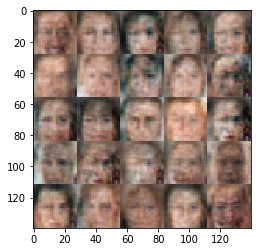

Epoch 0/1... Discriminator Loss: 0.8425... Generator Loss: 1.2646
Epoch 0/1... Discriminator Loss: 0.8581... Generator Loss: 1.2588
Epoch 0/1... Discriminator Loss: 0.9227... Generator Loss: 1.1361
Epoch 0/1... Discriminator Loss: 0.7172... Generator Loss: 1.1609
Epoch 0/1... Discriminator Loss: 0.6630... Generator Loss: 1.3862
Epoch 0/1... Discriminator Loss: 1.1380... Generator Loss: 1.1742
Epoch 0/1... Discriminator Loss: 0.7889... Generator Loss: 1.2386
Epoch 0/1... Discriminator Loss: 0.9542... Generator Loss: 0.8410
Epoch 0/1... Discriminator Loss: 0.8900... Generator Loss: 1.2380
Epoch 0/1... Discriminator Loss: 1.1921... Generator Loss: 1.4419


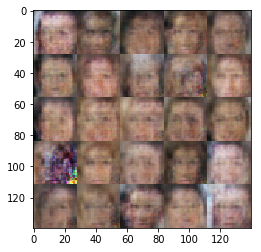

Epoch 0/1... Discriminator Loss: 1.1942... Generator Loss: 0.9921
Epoch 0/1... Discriminator Loss: 0.7411... Generator Loss: 1.1413
Epoch 0/1... Discriminator Loss: 1.0337... Generator Loss: 1.4910
Epoch 0/1... Discriminator Loss: 0.7953... Generator Loss: 1.3065
Epoch 0/1... Discriminator Loss: 0.9655... Generator Loss: 0.9697
Epoch 0/1... Discriminator Loss: 1.2231... Generator Loss: 0.8936
Epoch 0/1... Discriminator Loss: 0.6839... Generator Loss: 1.1586
Epoch 0/1... Discriminator Loss: 0.9512... Generator Loss: 0.7722
Epoch 0/1... Discriminator Loss: 0.9630... Generator Loss: 2.7062
Epoch 0/1... Discriminator Loss: 0.7683... Generator Loss: 1.3262


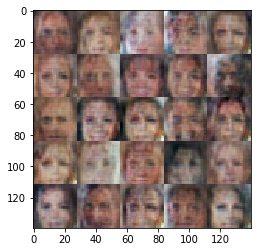

Epoch 0/1... Discriminator Loss: 1.2954... Generator Loss: 0.7410
Epoch 0/1... Discriminator Loss: 0.7272... Generator Loss: 1.8765
Epoch 0/1... Discriminator Loss: 0.8419... Generator Loss: 1.4175
Epoch 0/1... Discriminator Loss: 0.8276... Generator Loss: 1.0351
Epoch 0/1... Discriminator Loss: 0.9350... Generator Loss: 1.8303
Epoch 0/1... Discriminator Loss: 1.1267... Generator Loss: 1.0840
Epoch 0/1... Discriminator Loss: 0.9990... Generator Loss: 2.5797
Epoch 0/1... Discriminator Loss: 0.5532... Generator Loss: 2.2255
Epoch 0/1... Discriminator Loss: 0.7953... Generator Loss: 1.0784
Epoch 0/1... Discriminator Loss: 0.9702... Generator Loss: 1.7787


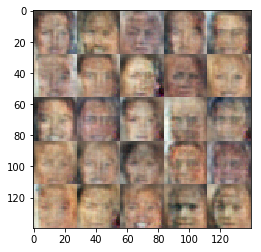

Epoch 0/1... Discriminator Loss: 0.8121... Generator Loss: 1.3616
Epoch 0/1... Discriminator Loss: 1.0124... Generator Loss: 0.9420
Epoch 0/1... Discriminator Loss: 0.8323... Generator Loss: 1.3029
Epoch 0/1... Discriminator Loss: 1.0470... Generator Loss: 0.7644
Epoch 0/1... Discriminator Loss: 1.1026... Generator Loss: 0.7419
Epoch 0/1... Discriminator Loss: 0.9641... Generator Loss: 0.8765
Epoch 0/1... Discriminator Loss: 0.8234... Generator Loss: 1.4600
Epoch 0/1... Discriminator Loss: 1.0896... Generator Loss: 0.7504
Epoch 0/1... Discriminator Loss: 0.9498... Generator Loss: 1.0087
Epoch 0/1... Discriminator Loss: 0.8600... Generator Loss: 1.2254


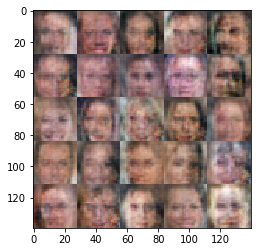

Epoch 0/1... Discriminator Loss: 1.0784... Generator Loss: 0.8873
Epoch 0/1... Discriminator Loss: 1.5684... Generator Loss: 0.4219
Epoch 0/1... Discriminator Loss: 1.0098... Generator Loss: 1.1548
Epoch 0/1... Discriminator Loss: 0.7793... Generator Loss: 1.6742
Epoch 0/1... Discriminator Loss: 1.1674... Generator Loss: 0.6904
Epoch 0/1... Discriminator Loss: 0.9173... Generator Loss: 1.9147
Epoch 0/1... Discriminator Loss: 1.1141... Generator Loss: 0.9837
Epoch 0/1... Discriminator Loss: 0.8450... Generator Loss: 1.4918
Epoch 0/1... Discriminator Loss: 0.7330... Generator Loss: 1.9937
Epoch 0/1... Discriminator Loss: 0.9080... Generator Loss: 1.7316


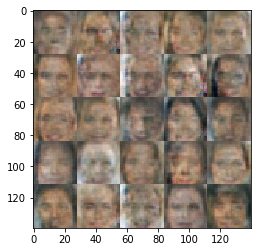

Epoch 0/1... Discriminator Loss: 0.7173... Generator Loss: 1.6297
Epoch 0/1... Discriminator Loss: 1.1000... Generator Loss: 1.0070
Epoch 0/1... Discriminator Loss: 0.8841... Generator Loss: 1.0066
Epoch 0/1... Discriminator Loss: 0.8737... Generator Loss: 1.7721
Epoch 0/1... Discriminator Loss: 1.0809... Generator Loss: 0.6735
Epoch 0/1... Discriminator Loss: 1.0816... Generator Loss: 1.2690
Epoch 0/1... Discriminator Loss: 1.0331... Generator Loss: 0.8165
Epoch 0/1... Discriminator Loss: 0.5655... Generator Loss: 1.8097
Epoch 0/1... Discriminator Loss: 1.5016... Generator Loss: 0.4819
Epoch 0/1... Discriminator Loss: 0.9987... Generator Loss: 1.0010


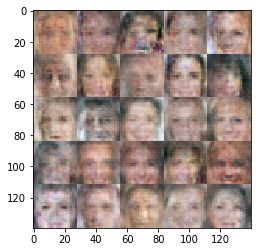

Epoch 0/1... Discriminator Loss: 1.1516... Generator Loss: 0.7513
Epoch 0/1... Discriminator Loss: 0.7758... Generator Loss: 1.0664
Epoch 0/1... Discriminator Loss: 0.8314... Generator Loss: 0.7786
Epoch 0/1... Discriminator Loss: 0.8583... Generator Loss: 1.0670
Epoch 0/1... Discriminator Loss: 0.6450... Generator Loss: 1.5800
Epoch 0/1... Discriminator Loss: 0.9186... Generator Loss: 1.0077
Epoch 0/1... Discriminator Loss: 1.0137... Generator Loss: 1.1753
Epoch 0/1... Discriminator Loss: 0.7381... Generator Loss: 1.2139
Epoch 0/1... Discriminator Loss: 1.4712... Generator Loss: 0.4219
Epoch 0/1... Discriminator Loss: 0.6348... Generator Loss: 1.4145


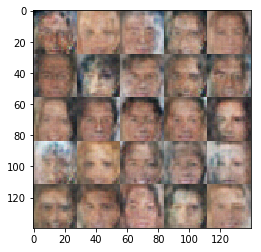

Epoch 0/1... Discriminator Loss: 0.6505... Generator Loss: 1.7151
Epoch 0/1... Discriminator Loss: 0.5372... Generator Loss: 1.7652
Epoch 0/1... Discriminator Loss: 1.0052... Generator Loss: 0.7239
Epoch 0/1... Discriminator Loss: 0.6696... Generator Loss: 1.6895
Epoch 0/1... Discriminator Loss: 1.0578... Generator Loss: 1.1507
Epoch 0/1... Discriminator Loss: 0.7703... Generator Loss: 1.2766
Epoch 0/1... Discriminator Loss: 0.7819... Generator Loss: 1.1332
Epoch 0/1... Discriminator Loss: 0.7363... Generator Loss: 1.5393
Epoch 0/1... Discriminator Loss: 0.9752... Generator Loss: 0.8629
Epoch 0/1... Discriminator Loss: 0.8318... Generator Loss: 1.1285


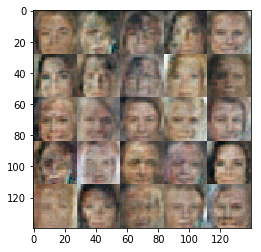

Epoch 0/1... Discriminator Loss: 0.9939... Generator Loss: 0.8417
Epoch 0/1... Discriminator Loss: 1.0071... Generator Loss: 1.0845
Epoch 0/1... Discriminator Loss: 0.7941... Generator Loss: 1.4900
Epoch 0/1... Discriminator Loss: 1.2809... Generator Loss: 1.0436
Epoch 0/1... Discriminator Loss: 0.7155... Generator Loss: 1.6079
Epoch 0/1... Discriminator Loss: 0.9129... Generator Loss: 1.8542
Epoch 0/1... Discriminator Loss: 1.1693... Generator Loss: 0.6831
Epoch 0/1... Discriminator Loss: 0.8332... Generator Loss: 1.3877
Epoch 0/1... Discriminator Loss: 0.8430... Generator Loss: 1.0457
Epoch 0/1... Discriminator Loss: 1.0742... Generator Loss: 0.7329


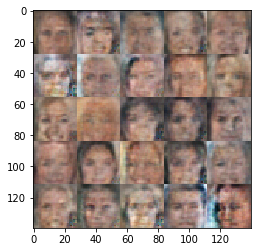

Epoch 0/1... Discriminator Loss: 1.0847... Generator Loss: 0.8358
Epoch 0/1... Discriminator Loss: 0.7433... Generator Loss: 1.2467
Epoch 0/1... Discriminator Loss: 0.8696... Generator Loss: 1.0426
Epoch 0/1... Discriminator Loss: 0.7791... Generator Loss: 1.7397
Epoch 0/1... Discriminator Loss: 0.6983... Generator Loss: 1.3621
Epoch 0/1... Discriminator Loss: 0.8277... Generator Loss: 1.0652
Epoch 0/1... Discriminator Loss: 0.7791... Generator Loss: 0.9648
Epoch 0/1... Discriminator Loss: 0.6556... Generator Loss: 1.7211
Epoch 0/1... Discriminator Loss: 1.4847... Generator Loss: 0.4962
Epoch 0/1... Discriminator Loss: 0.7699... Generator Loss: 1.1685


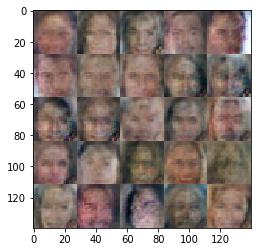

Epoch 0/1... Discriminator Loss: 1.1452... Generator Loss: 0.7028
Epoch 0/1... Discriminator Loss: 0.7557... Generator Loss: 1.3324
Epoch 0/1... Discriminator Loss: 1.5911... Generator Loss: 0.5038
Epoch 0/1... Discriminator Loss: 0.6408... Generator Loss: 1.7621
Epoch 0/1... Discriminator Loss: 0.9148... Generator Loss: 1.1081
Epoch 0/1... Discriminator Loss: 1.2075... Generator Loss: 0.6186
Epoch 0/1... Discriminator Loss: 0.9247... Generator Loss: 1.1844
Epoch 0/1... Discriminator Loss: 1.0062... Generator Loss: 0.8522
Epoch 0/1... Discriminator Loss: 1.1094... Generator Loss: 0.8178
Epoch 0/1... Discriminator Loss: 0.7593... Generator Loss: 1.0062


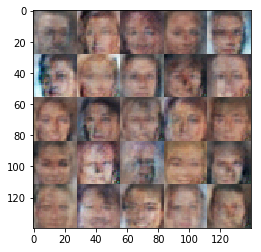

Epoch 0/1... Discriminator Loss: 1.0851... Generator Loss: 0.8795
Epoch 0/1... Discriminator Loss: 0.9072... Generator Loss: 1.2165
Epoch 0/1... Discriminator Loss: 0.9951... Generator Loss: 0.9461
Epoch 0/1... Discriminator Loss: 0.9835... Generator Loss: 1.2467
Epoch 0/1... Discriminator Loss: 0.6934... Generator Loss: 1.2383
Epoch 0/1... Discriminator Loss: 0.5663... Generator Loss: 2.2749
Epoch 0/1... Discriminator Loss: 0.7308... Generator Loss: 0.9898
Epoch 0/1... Discriminator Loss: 0.8644... Generator Loss: 0.8965
Epoch 0/1... Discriminator Loss: 0.6911... Generator Loss: 1.8650
Epoch 0/1... Discriminator Loss: 0.8887... Generator Loss: 0.8537


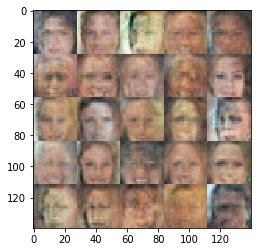

Epoch 0/1... Discriminator Loss: 0.9437... Generator Loss: 0.8430
Epoch 0/1... Discriminator Loss: 0.7499... Generator Loss: 1.1580
Epoch 0/1... Discriminator Loss: 1.3417... Generator Loss: 0.5322
Epoch 0/1... Discriminator Loss: 0.8463... Generator Loss: 1.1672
Epoch 0/1... Discriminator Loss: 0.9542... Generator Loss: 0.9759
Epoch 0/1... Discriminator Loss: 0.4907... Generator Loss: 2.0751
Epoch 0/1... Discriminator Loss: 0.6097... Generator Loss: 1.9790
Epoch 0/1... Discriminator Loss: 1.0727... Generator Loss: 1.4753
Epoch 0/1... Discriminator Loss: 1.2786... Generator Loss: 0.9526
Epoch 0/1... Discriminator Loss: 0.7809... Generator Loss: 1.7795


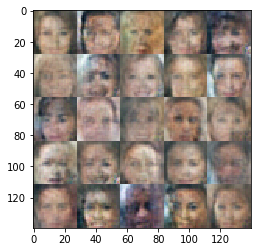

Epoch 0/1... Discriminator Loss: 1.3061... Generator Loss: 0.7748
Epoch 0/1... Discriminator Loss: 0.8807... Generator Loss: 0.9769
Epoch 0/1... Discriminator Loss: 1.1556... Generator Loss: 1.2359
Epoch 0/1... Discriminator Loss: 1.1399... Generator Loss: 1.0730
Epoch 0/1... Discriminator Loss: 0.8608... Generator Loss: 1.1268
Epoch 0/1... Discriminator Loss: 1.0962... Generator Loss: 1.7455
Epoch 0/1... Discriminator Loss: 0.9305... Generator Loss: 0.8423
Epoch 0/1... Discriminator Loss: 1.0636... Generator Loss: 0.8841
Epoch 0/1... Discriminator Loss: 1.8415... Generator Loss: 0.2687
Epoch 0/1... Discriminator Loss: 1.2198... Generator Loss: 0.4616


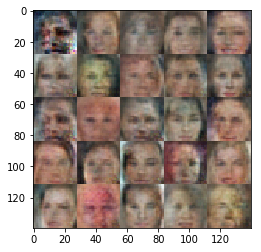

Epoch 0/1... Discriminator Loss: 1.0986... Generator Loss: 0.7203
Epoch 0/1... Discriminator Loss: 1.0725... Generator Loss: 0.7156
Epoch 0/1... Discriminator Loss: 0.8677... Generator Loss: 1.1243
Epoch 0/1... Discriminator Loss: 0.7819... Generator Loss: 1.4268
Epoch 0/1... Discriminator Loss: 0.8992... Generator Loss: 1.4338
Epoch 0/1... Discriminator Loss: 1.3373... Generator Loss: 0.7066
Epoch 0/1... Discriminator Loss: 0.8540... Generator Loss: 0.9918
Epoch 0/1... Discriminator Loss: 0.9617... Generator Loss: 0.9827
Epoch 0/1... Discriminator Loss: 0.9680... Generator Loss: 0.8352
Epoch 0/1... Discriminator Loss: 1.2338... Generator Loss: 0.7747


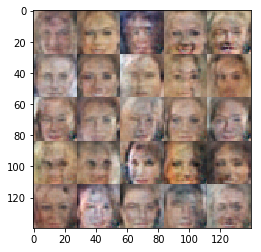

Epoch 0/1... Discriminator Loss: 0.6535... Generator Loss: 1.6007
Epoch 0/1... Discriminator Loss: 1.1000... Generator Loss: 0.7950
Epoch 0/1... Discriminator Loss: 1.1125... Generator Loss: 0.6771
Epoch 0/1... Discriminator Loss: 0.7424... Generator Loss: 1.3766
Epoch 0/1... Discriminator Loss: 0.6832... Generator Loss: 1.1346
Epoch 0/1... Discriminator Loss: 0.5203... Generator Loss: 1.4462
Epoch 0/1... Discriminator Loss: 0.9169... Generator Loss: 1.0495
Epoch 0/1... Discriminator Loss: 0.7506... Generator Loss: 1.5577
Epoch 0/1... Discriminator Loss: 1.2354... Generator Loss: 0.6620
Epoch 0/1... Discriminator Loss: 0.9138... Generator Loss: 0.7905


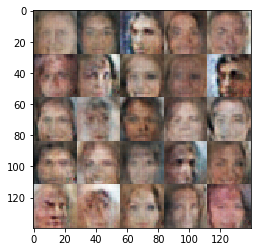

Epoch 0/1... Discriminator Loss: 0.8979... Generator Loss: 0.9171
Epoch 0/1... Discriminator Loss: 0.6404... Generator Loss: 1.6304
Epoch 0/1... Discriminator Loss: 0.7348... Generator Loss: 1.3178
Epoch 0/1... Discriminator Loss: 0.9617... Generator Loss: 1.1086
Epoch 0/1... Discriminator Loss: 0.8225... Generator Loss: 1.2090
Epoch 0/1... Discriminator Loss: 1.1860... Generator Loss: 1.8620
Epoch 0/1... Discriminator Loss: 0.9374... Generator Loss: 1.1016
Epoch 0/1... Discriminator Loss: 0.8323... Generator Loss: 1.2437
Epoch 0/1... Discriminator Loss: 1.0874... Generator Loss: 0.6581
Epoch 0/1... Discriminator Loss: 0.7981... Generator Loss: 1.6396


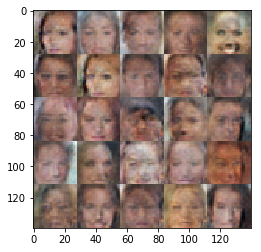

Epoch 0/1... Discriminator Loss: 0.6418... Generator Loss: 1.4270
Epoch 0/1... Discriminator Loss: 1.0357... Generator Loss: 0.9202
Epoch 0/1... Discriminator Loss: 1.2209... Generator Loss: 0.7286
Epoch 0/1... Discriminator Loss: 0.8158... Generator Loss: 1.1165
Epoch 0/1... Discriminator Loss: 1.3531... Generator Loss: 1.2304
Epoch 0/1... Discriminator Loss: 1.0118... Generator Loss: 1.3727
Epoch 0/1... Discriminator Loss: 0.8288... Generator Loss: 1.0358
Epoch 0/1... Discriminator Loss: 1.2745... Generator Loss: 0.4716
Epoch 0/1... Discriminator Loss: 0.8354... Generator Loss: 1.1200
Epoch 0/1... Discriminator Loss: 1.0070... Generator Loss: 0.8322


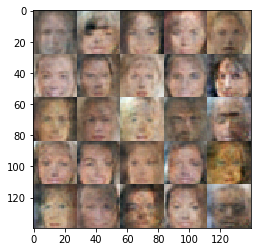

Epoch 0/1... Discriminator Loss: 0.7314... Generator Loss: 1.7417
Epoch 0/1... Discriminator Loss: 0.9269... Generator Loss: 0.9416
Epoch 0/1... Discriminator Loss: 1.0220... Generator Loss: 0.7637
Epoch 0/1... Discriminator Loss: 1.0941... Generator Loss: 0.7678
Epoch 0/1... Discriminator Loss: 0.8022... Generator Loss: 1.0012
Epoch 0/1... Discriminator Loss: 0.3853... Generator Loss: 2.2635
Epoch 0/1... Discriminator Loss: 0.9120... Generator Loss: 1.0842
Epoch 0/1... Discriminator Loss: 0.7112... Generator Loss: 1.4949
Epoch 0/1... Discriminator Loss: 0.9586... Generator Loss: 1.1713
Epoch 0/1... Discriminator Loss: 0.9708... Generator Loss: 0.9966


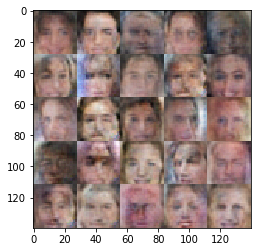

Epoch 0/1... Discriminator Loss: 0.9968... Generator Loss: 0.8102
Epoch 0/1... Discriminator Loss: 0.9499... Generator Loss: 1.2833
Epoch 0/1... Discriminator Loss: 1.1142... Generator Loss: 0.9261
Epoch 0/1... Discriminator Loss: 0.7855... Generator Loss: 1.1249
Epoch 0/1... Discriminator Loss: 0.9804... Generator Loss: 0.8189
Epoch 0/1... Discriminator Loss: 0.5611... Generator Loss: 2.3451
Epoch 0/1... Discriminator Loss: 1.0479... Generator Loss: 0.7802
Epoch 0/1... Discriminator Loss: 1.1469... Generator Loss: 1.0618
Epoch 0/1... Discriminator Loss: 0.9143... Generator Loss: 1.5826
Epoch 0/1... Discriminator Loss: 0.9244... Generator Loss: 0.8319


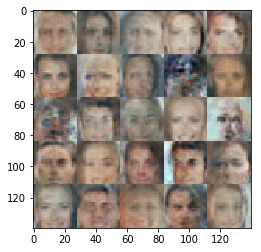

Epoch 0/1... Discriminator Loss: 0.8456... Generator Loss: 1.1563
Epoch 0/1... Discriminator Loss: 0.8826... Generator Loss: 0.8697
Epoch 0/1... Discriminator Loss: 1.0526... Generator Loss: 1.0748
Epoch 0/1... Discriminator Loss: 0.7047... Generator Loss: 1.3200
Epoch 0/1... Discriminator Loss: 0.8516... Generator Loss: 1.1648
Epoch 0/1... Discriminator Loss: 0.5029... Generator Loss: 1.6498
Epoch 0/1... Discriminator Loss: 1.0760... Generator Loss: 0.5619
Epoch 0/1... Discriminator Loss: 0.6494... Generator Loss: 1.3358
Epoch 0/1... Discriminator Loss: 0.6819... Generator Loss: 1.6013
Epoch 0/1... Discriminator Loss: 0.9385... Generator Loss: 0.9824


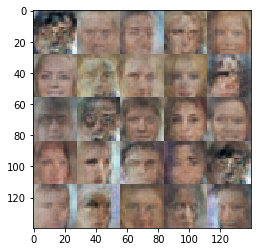

Epoch 0/1... Discriminator Loss: 0.9092... Generator Loss: 0.8454
Epoch 0/1... Discriminator Loss: 0.7689... Generator Loss: 1.2047
Epoch 0/1... Discriminator Loss: 0.9927... Generator Loss: 2.0099
Epoch 0/1... Discriminator Loss: 1.1408... Generator Loss: 1.2408
Epoch 0/1... Discriminator Loss: 0.6288... Generator Loss: 1.3130
Epoch 0/1... Discriminator Loss: 0.9088... Generator Loss: 1.1242
Epoch 0/1... Discriminator Loss: 0.5790... Generator Loss: 1.8293
Epoch 0/1... Discriminator Loss: 0.9952... Generator Loss: 1.4365
Epoch 0/1... Discriminator Loss: 0.9585... Generator Loss: 0.7945
Epoch 0/1... Discriminator Loss: 1.3580... Generator Loss: 1.1204


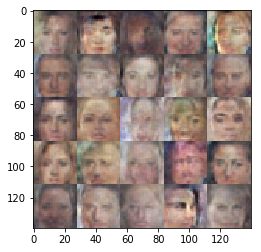

Epoch 0/1... Discriminator Loss: 0.7136... Generator Loss: 1.5691
Epoch 0/1... Discriminator Loss: 0.7626... Generator Loss: 1.1642
Epoch 0/1... Discriminator Loss: 1.4611... Generator Loss: 0.3781
Epoch 0/1... Discriminator Loss: 0.7095... Generator Loss: 1.3276
Epoch 0/1... Discriminator Loss: 0.8016... Generator Loss: 1.1784
Epoch 0/1... Discriminator Loss: 0.7353... Generator Loss: 1.3199
Epoch 0/1... Discriminator Loss: 0.9709... Generator Loss: 0.9892
Epoch 0/1... Discriminator Loss: 0.6247... Generator Loss: 1.5798
Epoch 0/1... Discriminator Loss: 1.1759... Generator Loss: 0.5496
Epoch 0/1... Discriminator Loss: 1.0547... Generator Loss: 0.8101


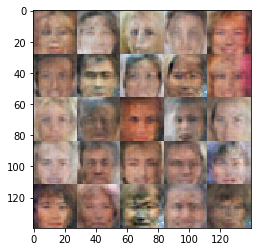

Epoch 0/1... Discriminator Loss: 0.5659... Generator Loss: 2.0132
Epoch 0/1... Discriminator Loss: 0.5490... Generator Loss: 1.8107
Epoch 0/1... Discriminator Loss: 0.5519... Generator Loss: 1.5567
Epoch 0/1... Discriminator Loss: 0.7315... Generator Loss: 1.5399
Epoch 0/1... Discriminator Loss: 1.3118... Generator Loss: 0.5376
Epoch 0/1... Discriminator Loss: 0.5374... Generator Loss: 1.6440
Epoch 0/1... Discriminator Loss: 1.6363... Generator Loss: 2.7169
Epoch 0/1... Discriminator Loss: 1.1098... Generator Loss: 0.6465
Epoch 0/1... Discriminator Loss: 1.8680... Generator Loss: 0.2512
Epoch 0/1... Discriminator Loss: 0.8170... Generator Loss: 1.3758


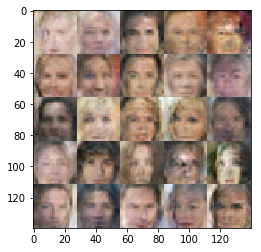

Epoch 0/1... Discriminator Loss: 0.9960... Generator Loss: 0.7228
Epoch 0/1... Discriminator Loss: 1.2768... Generator Loss: 0.8681
Epoch 0/1... Discriminator Loss: 1.0250... Generator Loss: 0.7594
Epoch 0/1... Discriminator Loss: 0.7987... Generator Loss: 1.2433
Epoch 0/1... Discriminator Loss: 1.0045... Generator Loss: 1.0578
Epoch 0/1... Discriminator Loss: 1.1043... Generator Loss: 1.2607
Epoch 0/1... Discriminator Loss: 0.8228... Generator Loss: 1.1622
Epoch 0/1... Discriminator Loss: 1.2540... Generator Loss: 0.7286
Epoch 0/1... Discriminator Loss: 0.9819... Generator Loss: 0.7829
Epoch 0/1... Discriminator Loss: 0.7362... Generator Loss: 1.2195


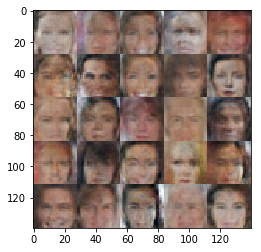

Epoch 0/1... Discriminator Loss: 1.0827... Generator Loss: 0.8053
Epoch 0/1... Discriminator Loss: 1.1142... Generator Loss: 0.7822
Epoch 0/1... Discriminator Loss: 1.1165... Generator Loss: 0.7251
Epoch 0/1... Discriminator Loss: 0.4222... Generator Loss: 2.3509
Epoch 0/1... Discriminator Loss: 0.5796... Generator Loss: 1.2442
Epoch 0/1... Discriminator Loss: 0.8115... Generator Loss: 1.3234
Epoch 0/1... Discriminator Loss: 0.5359... Generator Loss: 2.3230
Epoch 0/1... Discriminator Loss: 0.9143... Generator Loss: 1.2106
Epoch 0/1... Discriminator Loss: 0.6481... Generator Loss: 1.4189
Epoch 0/1... Discriminator Loss: 0.8211... Generator Loss: 1.0759


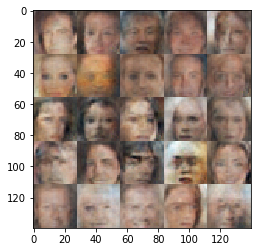

Epoch 0/1... Discriminator Loss: 0.6750... Generator Loss: 1.0808
Epoch 0/1... Discriminator Loss: 0.6651... Generator Loss: 1.8022
Epoch 0/1... Discriminator Loss: 0.7113... Generator Loss: 1.1273
Epoch 0/1... Discriminator Loss: 0.6673... Generator Loss: 1.4523
Epoch 0/1... Discriminator Loss: 0.9138... Generator Loss: 0.7660
Epoch 0/1... Discriminator Loss: 0.8631... Generator Loss: 0.8583
Epoch 0/1... Discriminator Loss: 0.7972... Generator Loss: 1.0399
Epoch 0/1... Discriminator Loss: 0.6046... Generator Loss: 1.2297
Epoch 0/1... Discriminator Loss: 0.3042... Generator Loss: 1.9209
Epoch 0/1... Discriminator Loss: 0.9617... Generator Loss: 0.9024


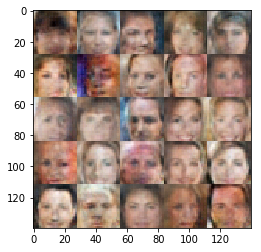

Epoch 0/1... Discriminator Loss: 0.8945... Generator Loss: 1.0771
Epoch 0/1... Discriminator Loss: 0.7224... Generator Loss: 1.7865
Epoch 0/1... Discriminator Loss: 0.8389... Generator Loss: 1.0864
Epoch 0/1... Discriminator Loss: 1.5712... Generator Loss: 0.4963
Epoch 0/1... Discriminator Loss: 0.8797... Generator Loss: 0.9531
Epoch 0/1... Discriminator Loss: 0.9465... Generator Loss: 1.0212
Epoch 0/1... Discriminator Loss: 0.9689... Generator Loss: 0.9244
Epoch 0/1... Discriminator Loss: 1.1404... Generator Loss: 0.6744
Epoch 0/1... Discriminator Loss: 0.5882... Generator Loss: 1.6486
Epoch 0/1... Discriminator Loss: 0.9419... Generator Loss: 2.2120


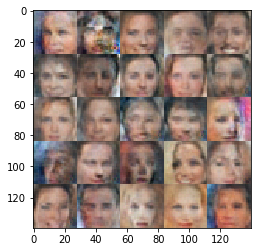

Epoch 0/1... Discriminator Loss: 0.9145... Generator Loss: 0.9634
Epoch 0/1... Discriminator Loss: 0.6154... Generator Loss: 1.2198
Epoch 0/1... Discriminator Loss: 0.7442... Generator Loss: 1.0383
Epoch 0/1... Discriminator Loss: 0.8047... Generator Loss: 1.0753
Epoch 0/1... Discriminator Loss: 0.7069... Generator Loss: 1.2403
Epoch 0/1... Discriminator Loss: 0.6227... Generator Loss: 1.6226
Epoch 0/1... Discriminator Loss: 0.8625... Generator Loss: 1.1923
Epoch 0/1... Discriminator Loss: 0.9318... Generator Loss: 2.0699
Epoch 0/1... Discriminator Loss: 0.8828... Generator Loss: 1.1634
Epoch 0/1... Discriminator Loss: 0.7242... Generator Loss: 1.1913


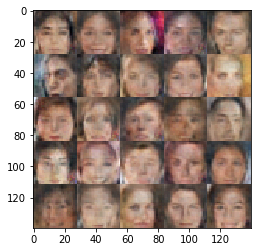

Epoch 0/1... Discriminator Loss: 0.9687... Generator Loss: 0.8427
Epoch 0/1... Discriminator Loss: 0.7159... Generator Loss: 1.7825
Epoch 0/1... Discriminator Loss: 1.7257... Generator Loss: 0.9118
Epoch 0/1... Discriminator Loss: 0.8623... Generator Loss: 0.9774
Epoch 0/1... Discriminator Loss: 0.6899... Generator Loss: 1.2926
Epoch 0/1... Discriminator Loss: 0.6931... Generator Loss: 1.2949
Epoch 0/1... Discriminator Loss: 0.5575... Generator Loss: 1.5715
Epoch 0/1... Discriminator Loss: 0.6930... Generator Loss: 1.4268
Epoch 0/1... Discriminator Loss: 0.7546... Generator Loss: 1.7372
Epoch 0/1... Discriminator Loss: 0.9588... Generator Loss: 1.1603


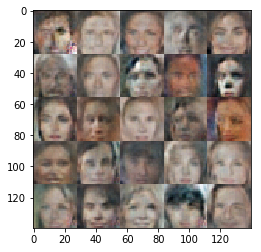

Epoch 0/1... Discriminator Loss: 0.5511... Generator Loss: 2.0485
Epoch 0/1... Discriminator Loss: 0.9129... Generator Loss: 0.8879
Epoch 0/1... Discriminator Loss: 0.7790... Generator Loss: 1.3401
Epoch 0/1... Discriminator Loss: 0.7975... Generator Loss: 1.0369
Epoch 0/1... Discriminator Loss: 0.9901... Generator Loss: 0.8069
Epoch 0/1... Discriminator Loss: 0.8551... Generator Loss: 1.0128
Epoch 0/1... Discriminator Loss: 1.0414... Generator Loss: 1.0210
Epoch 0/1... Discriminator Loss: 1.0936... Generator Loss: 0.9202
Epoch 0/1... Discriminator Loss: 0.8404... Generator Loss: 1.6112
Epoch 0/1... Discriminator Loss: 0.7332... Generator Loss: 1.1616


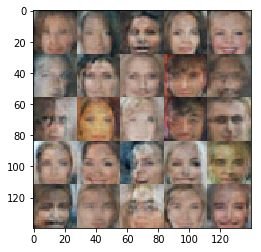

Epoch 0/1... Discriminator Loss: 1.1318... Generator Loss: 0.6788
Epoch 0/1... Discriminator Loss: 0.9499... Generator Loss: 1.0275
Epoch 0/1... Discriminator Loss: 0.8327... Generator Loss: 1.1622
Epoch 0/1... Discriminator Loss: 0.7526... Generator Loss: 1.2463
Epoch 0/1... Discriminator Loss: 0.6558... Generator Loss: 1.3942
Epoch 0/1... Discriminator Loss: 1.0341... Generator Loss: 1.0810
Epoch 0/1... Discriminator Loss: 0.7114... Generator Loss: 1.7499
Epoch 0/1... Discriminator Loss: 0.8303... Generator Loss: 1.2444
Epoch 0/1... Discriminator Loss: 0.8414... Generator Loss: 1.1223
Epoch 0/1... Discriminator Loss: 0.5915... Generator Loss: 1.4524


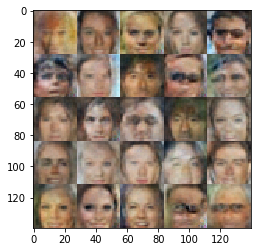

Epoch 0/1... Discriminator Loss: 1.0482... Generator Loss: 1.5274
Epoch 0/1... Discriminator Loss: 1.0007... Generator Loss: 0.8524
Epoch 0/1... Discriminator Loss: 0.9253... Generator Loss: 1.2654
Epoch 0/1... Discriminator Loss: 0.8260... Generator Loss: 1.0529
Epoch 0/1... Discriminator Loss: 0.3812... Generator Loss: 1.9367
Epoch 0/1... Discriminator Loss: 0.7915... Generator Loss: 2.6188
Epoch 0/1... Discriminator Loss: 0.8142... Generator Loss: 2.9915
Epoch 0/1... Discriminator Loss: 0.9768... Generator Loss: 0.7614
Epoch 0/1... Discriminator Loss: 0.6165... Generator Loss: 1.4013
Epoch 0/1... Discriminator Loss: 0.6118... Generator Loss: 1.5584


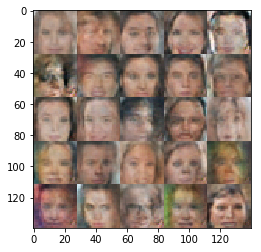

Epoch 0/1... Discriminator Loss: 0.8497... Generator Loss: 1.1243
Epoch 0/1... Discriminator Loss: 0.9078... Generator Loss: 1.0874
Epoch 0/1... Discriminator Loss: 0.8871... Generator Loss: 1.1147
Epoch 0/1... Discriminator Loss: 1.3186... Generator Loss: 0.7593
Epoch 0/1... Discriminator Loss: 0.8507... Generator Loss: 1.4266
Epoch 0/1... Discriminator Loss: 0.8456... Generator Loss: 1.0397
Epoch 0/1... Discriminator Loss: 0.9587... Generator Loss: 0.8903
Epoch 0/1... Discriminator Loss: 0.7357... Generator Loss: 1.4396
Epoch 0/1... Discriminator Loss: 0.7350... Generator Loss: 1.0518
Epoch 0/1... Discriminator Loss: 0.9001... Generator Loss: 1.8200


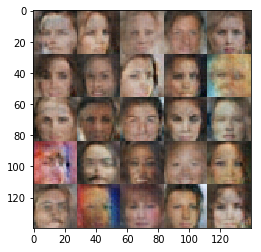

Epoch 0/1... Discriminator Loss: 0.8575... Generator Loss: 1.2933
Epoch 0/1... Discriminator Loss: 0.8208... Generator Loss: 0.9770
Epoch 0/1... Discriminator Loss: 0.7439... Generator Loss: 1.3745
Epoch 0/1... Discriminator Loss: 0.8803... Generator Loss: 0.8967
Epoch 0/1... Discriminator Loss: 1.0400... Generator Loss: 0.9025
Epoch 0/1... Discriminator Loss: 0.7252... Generator Loss: 1.2083
Epoch 0/1... Discriminator Loss: 0.5826... Generator Loss: 1.6517
Epoch 0/1... Discriminator Loss: 0.6449... Generator Loss: 1.9630
Epoch 0/1... Discriminator Loss: 0.7536... Generator Loss: 1.2020
Epoch 0/1... Discriminator Loss: 0.7516... Generator Loss: 1.1984


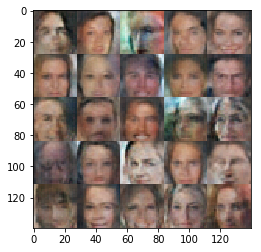

Epoch 0/1... Discriminator Loss: 0.9361... Generator Loss: 0.9466
Epoch 0/1... Discriminator Loss: 0.9433... Generator Loss: 2.4998
Epoch 0/1... Discriminator Loss: 0.6615... Generator Loss: 1.2826
Epoch 0/1... Discriminator Loss: 0.9070... Generator Loss: 1.1554
Epoch 0/1... Discriminator Loss: 0.9732... Generator Loss: 0.7409
Epoch 0/1... Discriminator Loss: 0.7025... Generator Loss: 1.2504
Epoch 0/1... Discriminator Loss: 0.6632... Generator Loss: 1.1903
Epoch 0/1... Discriminator Loss: 0.6675... Generator Loss: 1.4470
Epoch 0/1... Discriminator Loss: 0.5615... Generator Loss: 1.3974
Epoch 0/1... Discriminator Loss: 1.2778... Generator Loss: 0.6364


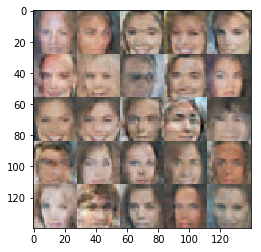

Epoch 0/1... Discriminator Loss: 1.0765... Generator Loss: 0.7631
Epoch 0/1... Discriminator Loss: 0.9359... Generator Loss: 0.9565
Epoch 0/1... Discriminator Loss: 0.9488... Generator Loss: 1.0001
Epoch 0/1... Discriminator Loss: 1.0658... Generator Loss: 1.0785
Epoch 0/1... Discriminator Loss: 1.0670... Generator Loss: 0.9105
Epoch 0/1... Discriminator Loss: 0.9129... Generator Loss: 0.8793
Epoch 0/1... Discriminator Loss: 1.0152... Generator Loss: 0.6815
Epoch 0/1... Discriminator Loss: 0.5514... Generator Loss: 3.2612
Epoch 0/1... Discriminator Loss: 0.5281... Generator Loss: 1.6967
Epoch 0/1... Discriminator Loss: 1.3534... Generator Loss: 1.5265


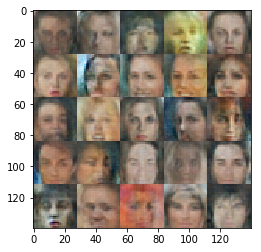

Epoch 0/1... Discriminator Loss: 0.9471... Generator Loss: 0.8690
Epoch 0/1... Discriminator Loss: 0.5004... Generator Loss: 1.5546
Epoch 0/1... Discriminator Loss: 0.8017... Generator Loss: 1.7659
Epoch 0/1... Discriminator Loss: 0.9087... Generator Loss: 1.3190
Epoch 0/1... Discriminator Loss: 0.8346... Generator Loss: 1.0606
Epoch 0/1... Discriminator Loss: 1.0784... Generator Loss: 0.6884
Epoch 0/1... Discriminator Loss: 0.7653... Generator Loss: 1.1809
Epoch 0/1... Discriminator Loss: 0.5984... Generator Loss: 1.3357
Epoch 0/1... Discriminator Loss: 1.0299... Generator Loss: 0.7286
Epoch 0/1... Discriminator Loss: 0.7378... Generator Loss: 1.1325


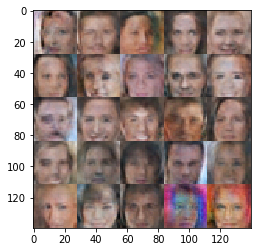

Epoch 0/1... Discriminator Loss: 0.8989... Generator Loss: 0.9747
Epoch 0/1... Discriminator Loss: 0.8656... Generator Loss: 0.8973
Epoch 0/1... Discriminator Loss: 0.8644... Generator Loss: 1.2555
Epoch 0/1... Discriminator Loss: 0.8990... Generator Loss: 0.9241
Epoch 0/1... Discriminator Loss: 0.6490... Generator Loss: 1.2375
Epoch 0/1... Discriminator Loss: 1.0367... Generator Loss: 0.9250
Epoch 0/1... Discriminator Loss: 0.9066... Generator Loss: 1.3672
Epoch 0/1... Discriminator Loss: 0.6855... Generator Loss: 1.1263
Epoch 0/1... Discriminator Loss: 0.4628... Generator Loss: 1.7813
Epoch 0/1... Discriminator Loss: 0.6519... Generator Loss: 1.5459


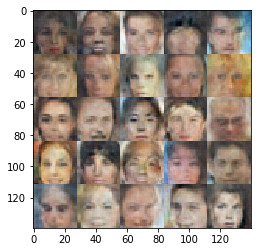

Epoch 0/1... Discriminator Loss: 0.8558... Generator Loss: 0.8514
Epoch 0/1... Discriminator Loss: 1.8951... Generator Loss: 3.7643
Epoch 0/1... Discriminator Loss: 0.6067... Generator Loss: 1.6018
Epoch 0/1... Discriminator Loss: 0.8867... Generator Loss: 0.9069
Epoch 0/1... Discriminator Loss: 1.0777... Generator Loss: 1.0251
Epoch 0/1... Discriminator Loss: 0.8092... Generator Loss: 1.0455
Epoch 0/1... Discriminator Loss: 0.9087... Generator Loss: 1.1155
Epoch 0/1... Discriminator Loss: 0.4237... Generator Loss: 2.8879
Epoch 0/1... Discriminator Loss: 0.6431... Generator Loss: 1.6875
Epoch 0/1... Discriminator Loss: 0.9441... Generator Loss: 0.9409


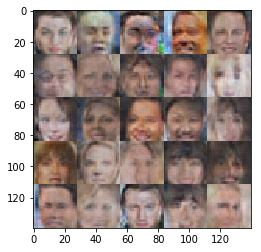

Epoch 0/1... Discriminator Loss: 0.9757... Generator Loss: 1.0874
Epoch 0/1... Discriminator Loss: 0.6924... Generator Loss: 1.3068
Epoch 0/1... Discriminator Loss: 0.6921... Generator Loss: 2.0944
Epoch 0/1... Discriminator Loss: 0.9099... Generator Loss: 1.0228
Epoch 0/1... Discriminator Loss: 0.9396... Generator Loss: 0.9226
Epoch 0/1... Discriminator Loss: 0.9885... Generator Loss: 0.9019
Epoch 0/1... Discriminator Loss: 0.9475... Generator Loss: 0.9849
Epoch 0/1... Discriminator Loss: 1.0388... Generator Loss: 0.8534
Epoch 0/1... Discriminator Loss: 0.7316... Generator Loss: 1.2172
Epoch 0/1... Discriminator Loss: 0.8032... Generator Loss: 1.1358


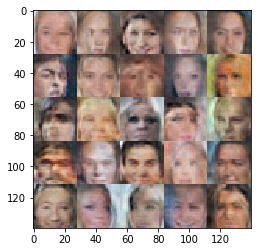

Epoch 0/1... Discriminator Loss: 0.7238... Generator Loss: 1.1826
Epoch 0/1... Discriminator Loss: 0.8887... Generator Loss: 1.2652
Epoch 0/1... Discriminator Loss: 0.9524... Generator Loss: 1.1545
Epoch 0/1... Discriminator Loss: 0.9647... Generator Loss: 0.8152
Epoch 0/1... Discriminator Loss: 1.0581... Generator Loss: 0.8488
Epoch 0/1... Discriminator Loss: 0.7888... Generator Loss: 1.0830
Epoch 0/1... Discriminator Loss: 1.1938... Generator Loss: 0.7482
Epoch 0/1... Discriminator Loss: 0.9237... Generator Loss: 0.9440
Epoch 0/1... Discriminator Loss: 0.6972... Generator Loss: 1.3335
Epoch 0/1... Discriminator Loss: 0.6535... Generator Loss: 1.4588


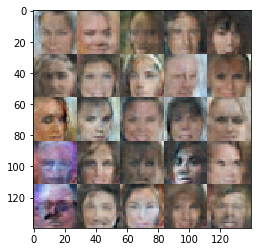

Epoch 0/1... Discriminator Loss: 0.4905... Generator Loss: 2.0966
Epoch 0/1... Discriminator Loss: 0.8762... Generator Loss: 1.2935
Epoch 0/1... Discriminator Loss: 0.6462... Generator Loss: 1.3991
Epoch 0/1... Discriminator Loss: 0.7882... Generator Loss: 1.2810
Epoch 0/1... Discriminator Loss: 0.6814... Generator Loss: 1.7074
Epoch 0/1... Discriminator Loss: 0.9292... Generator Loss: 0.8853
Epoch 0/1... Discriminator Loss: 0.7264... Generator Loss: 1.2089
Epoch 0/1... Discriminator Loss: 1.0224... Generator Loss: 0.8845
Epoch 0/1... Discriminator Loss: 0.7886... Generator Loss: 1.0011
Epoch 0/1... Discriminator Loss: 1.2407... Generator Loss: 1.2042


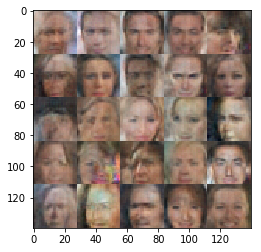

Epoch 0/1... Discriminator Loss: 0.9919... Generator Loss: 1.1825
Epoch 0/1... Discriminator Loss: 0.6594... Generator Loss: 2.7866
Epoch 0/1... Discriminator Loss: 0.4464... Generator Loss: 2.3849
Epoch 0/1... Discriminator Loss: 0.6893... Generator Loss: 1.1185
Epoch 0/1... Discriminator Loss: 0.5478... Generator Loss: 1.8863
Epoch 0/1... Discriminator Loss: 0.9512... Generator Loss: 0.9581
Epoch 0/1... Discriminator Loss: 0.9576... Generator Loss: 1.4346
Epoch 0/1... Discriminator Loss: 0.9948... Generator Loss: 1.0663
Epoch 0/1... Discriminator Loss: 0.9042... Generator Loss: 0.9047
Epoch 0/1... Discriminator Loss: 0.6803... Generator Loss: 1.2518


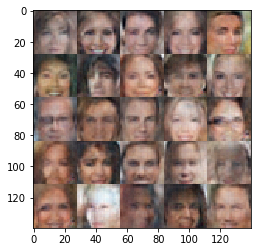

Epoch 0/1... Discriminator Loss: 0.7978... Generator Loss: 1.0264
Epoch 0/1... Discriminator Loss: 0.9877... Generator Loss: 1.2638
Epoch 0/1... Discriminator Loss: 1.0281... Generator Loss: 1.3307
Epoch 0/1... Discriminator Loss: 1.1382... Generator Loss: 0.8919
Epoch 0/1... Discriminator Loss: 0.5952... Generator Loss: 1.3995
Epoch 0/1... Discriminator Loss: 0.7316... Generator Loss: 1.4827
Epoch 0/1... Discriminator Loss: 1.0139... Generator Loss: 1.1773
Epoch 0/1... Discriminator Loss: 1.0813... Generator Loss: 0.9598
Epoch 0/1... Discriminator Loss: 0.8992... Generator Loss: 1.0825
Epoch 0/1... Discriminator Loss: 0.8655... Generator Loss: 1.2238


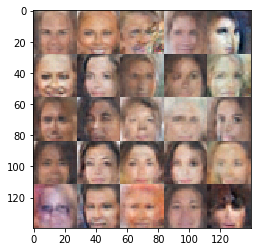

Epoch 0/1... Discriminator Loss: 0.7232... Generator Loss: 1.2007
Epoch 0/1... Discriminator Loss: 1.0265... Generator Loss: 1.3435
Epoch 0/1... Discriminator Loss: 0.9653... Generator Loss: 0.7886
Epoch 0/1... Discriminator Loss: 1.2970... Generator Loss: 0.6234
Epoch 0/1... Discriminator Loss: 0.8967... Generator Loss: 0.9424
Epoch 0/1... Discriminator Loss: 0.9043... Generator Loss: 1.0475
Epoch 0/1... Discriminator Loss: 0.9660... Generator Loss: 1.3487
Epoch 0/1... Discriminator Loss: 0.7752... Generator Loss: 1.2257
Epoch 0/1... Discriminator Loss: 0.7640... Generator Loss: 1.6597
Epoch 0/1... Discriminator Loss: 0.8225... Generator Loss: 1.1216


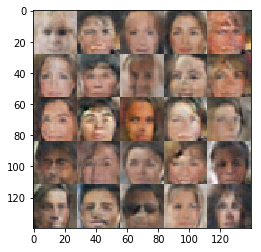

Epoch 0/1... Discriminator Loss: 0.8365... Generator Loss: 1.0557
Epoch 0/1... Discriminator Loss: 0.7760... Generator Loss: 1.4038
Epoch 0/1... Discriminator Loss: 0.9293... Generator Loss: 1.1163
Epoch 0/1... Discriminator Loss: 0.9513... Generator Loss: 1.4570
Epoch 0/1... Discriminator Loss: 1.0798... Generator Loss: 1.3440
Epoch 0/1... Discriminator Loss: 0.7871... Generator Loss: 1.5213
Epoch 0/1... Discriminator Loss: 0.6012... Generator Loss: 1.6107
Epoch 0/1... Discriminator Loss: 0.7604... Generator Loss: 1.1410
Epoch 0/1... Discriminator Loss: 1.4997... Generator Loss: 0.4834
Epoch 0/1... Discriminator Loss: 0.4832... Generator Loss: 2.0297


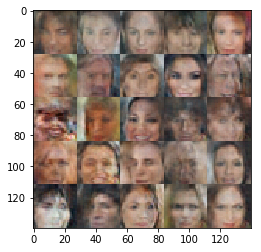

Epoch 0/1... Discriminator Loss: 1.0963... Generator Loss: 0.7767
Epoch 0/1... Discriminator Loss: 0.8168... Generator Loss: 1.0646
Epoch 0/1... Discriminator Loss: 0.9220... Generator Loss: 1.1421
Epoch 0/1... Discriminator Loss: 0.6393... Generator Loss: 1.7682
Epoch 0/1... Discriminator Loss: 0.8337... Generator Loss: 1.1129
Epoch 0/1... Discriminator Loss: 0.8740... Generator Loss: 1.0893
Epoch 0/1... Discriminator Loss: 0.7814... Generator Loss: 0.9886
Epoch 0/1... Discriminator Loss: 0.9074... Generator Loss: 1.3189
Epoch 0/1... Discriminator Loss: 0.7244... Generator Loss: 1.0881
Epoch 0/1... Discriminator Loss: 0.7242... Generator Loss: 1.1969


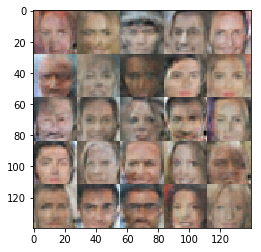

Epoch 0/1... Discriminator Loss: 0.8903... Generator Loss: 1.1614
Epoch 0/1... Discriminator Loss: 0.7674... Generator Loss: 1.2831
Epoch 0/1... Discriminator Loss: 0.6554... Generator Loss: 1.2362
Epoch 0/1... Discriminator Loss: 0.5770... Generator Loss: 1.6733
Epoch 0/1... Discriminator Loss: 0.7451... Generator Loss: 1.2426
Epoch 0/1... Discriminator Loss: 0.7392... Generator Loss: 1.0451
Epoch 0/1... Discriminator Loss: 1.1472... Generator Loss: 1.0170
Epoch 0/1... Discriminator Loss: 0.7100... Generator Loss: 1.3048
Epoch 0/1... Discriminator Loss: 0.6300... Generator Loss: 1.2239
Epoch 0/1... Discriminator Loss: 0.8577... Generator Loss: 1.2435


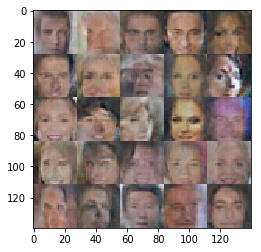

Epoch 0/1... Discriminator Loss: 0.7983... Generator Loss: 1.3405
Epoch 0/1... Discriminator Loss: 1.0307... Generator Loss: 0.8856
Epoch 0/1... Discriminator Loss: 0.7304... Generator Loss: 1.1212
Epoch 0/1... Discriminator Loss: 0.7309... Generator Loss: 1.1386
End


In [16]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.6

# learning_rate of the generator = 0.001

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.